## Introduction
Assume you have an image $I$ and an image database $X$ containing thousands of other images. You want to find a subset $S\subseteq X$ containing images that are most similar to $I$. This is a task called $image-retrieval$. But prior to solving this you may ask yourself, what is the meaning of similar images? Is it based on the $colors$ in the images? Or maybe the $content$? In the second case, two images containing dogs could be considered similar regardless of their breed, which obviously may have different colors.
In this post, I'll describe a simple implementation of this. The implementation is based on neural networks, and is done by comparing similarity between the embeddings of the two images.

##Method
Given a query image $I$, I extract the features using $VGG19$ and use the output of the $t^{th}$ VGG-block as the features I compare distances between. Below is an image describing the architecture of this network. As can be seen, the features will be vectors in $\mathbb{R}^{4096}$.

![vgg-19 architecture](https://www.researchgate.net/profile/Michael_Wurm/publication/331258180/figure/fig1/AS:728763826442243@1550762244632/Architecture-of-the-FCN-VGG19-adapted-from-Long-et-al-2015-which-learns-to-combine_W640.jpg)

The database I'll use is the train-set of $CIFAR-100$ (https://www.cs.toronto.edu/~kriz/cifar.html) which contains $50K$ images of 100 classes of various animals, flowers, vehicles, people, etc.

##Lets write some code!
The first think I'll do is importing all the necessary libraries for this project

In [1]:
import torch
from torch import nn, load, utils
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms, models
from torchvision.models.vgg import model_urls
from os import path, listdir
model_urls['vgg19'] = model_urls['vgg19'].replace('https://', 'http://')

#KNN search

Firstly, I'll describe how I search for the k closest points. I create a class for string all the features of my database and the corresponding images. If the database is too large, you may not be able to store all this data in the memory

In [2]:
class KNN:
	def __init__(self):
		self.images = []
		self.features = []

	def __len__(self):
		return len(self.images)

	def fit(self, x, x_features):
		"""
		:param x: (n_samples, sample_dim)
		"""
		self.images = x
		self.features = x_features

	def __getitem__(self, item):
		return self.images[item]

	def predict(self, query_features, k):
		if len(self) == 0:
			return None

		dists = np.array([self.single_image_distances(x_, k) for x_ in query_features])
		sorted_idx = np.argsort(a=dists, axis=1)
		return sorted_idx[:, :k]

	def single_image_distances(self, x, k):
		if k > len(self):
			return [list(range(len(self)))]
		return [np.linalg.norm(x - f) for f in self.features]

As we conisder `KNN`, the `fit` method simply stores the data. All the hard work is done in the `predict` method. Given features of the images used as queries, we calculate the `l_2` norm of difference between these features and every features of every image in the databse. The norm calculation is done by `np.linalg.norm` from `numpy`. Later, I sort all the distances based on their value and return the indexes of images of the `k` closest ones.

##Prepearing the model
For features extraction, I'll use the mentioned $VGG-19$ architecture, pretrained on $imagenet$. It is publicly available in `torchvision`. For simplicity, I create a class which defines the model.

In [3]:
class VGG:
	def __init__(self):
		model = models.vgg19(pretrained=True, progress=True)
		model.classifier = nn.Sequential(*list(model.classifier.children())[:3])
		self.model = model.cuda().eval()

	def __call__(self, x):
		return self.model(x)

The first line loads a pretrained model from `torchvision`. You can find other pretrained models in https://pytorch.org/docs/stable/torchvision/models.html.
The second line removes the last $fully-connected$ layers. Lastly, transfer the model to our GPU and use the `eval()` mode.

##Loading the data
I'll assume the query images are stored in a directory, because I want to use the built-in torchvision's loader.

In [4]:
def get_cifar100():
	transform = transforms.Compose([
		transforms.ToTensor(),
		transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
	])
	dataset = datasets.CIFAR100(
		root=r'./data', train=True, download=True, transform=transform)
	loader = utils.data.DataLoader(dataset, batch_size=100, shuffle=False, num_workers=1, pin_memory=True)
	return dataset, loader

In [5]:
def get_dataset(images_path):
  transform = transforms.Compose([
    transforms.Resize(size=32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
  ])

  dataset = datasets.ImageFolder(images_path, transform=transform)
  loader = utils.data.DataLoader(dataset, batch_size=100, shuffle=False, num_workers=1, pin_memory=True)
  return dataset, loader


##Features Extraction
The following method will extract the features of the images. It's supplied with a model (e.g. our $VGG-19$) and an image loader (whether the query images or the $CIFAR-100$ loader).

In [6]:
def get_features(model, loader):
    features = []
    with torch.no_grad():
        for batch, _ in tqdm(loader):
            if torch.cuda.is_available():
                batch = batch.cuda()
            b_features = model(batch).detach().cpu().numpy()
            for f in b_features:
                features.append(f)

    return features

##Retrieving Images

Now that we have all the code components, we'ere ready to run the queries. For this project, the query images are stored in a directory called `test_images`.

In [7]:
def show_grid():
  images = listdir(r'test_images/content')
  print(f"There are {len(images)} images")
  f, axarr = plt.subplots(4, 3)
  for img, ax in zip(images, axarr.flatten()):
    ax.imshow(plt.imread(path.join(r'test_images/content', img)))
    ax.set_yticklabels([])
    ax.set_xticklabels([])
  plt.tight_layout()
  plt.show()

There are 12 images


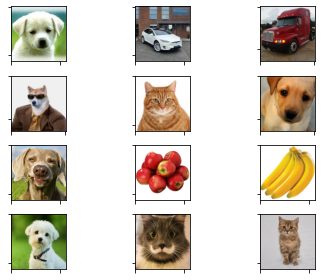

In [8]:
show_grid()

Get both loaders and model and extract the features. Later, use the KNN class to retrieve the 7 nearest neighbors

In [9]:
ret_dataset, ret_loader = get_dataset(r'test_images')
ret_paths = [a[0] for a in ret_dataset.imgs]
cifar_dataset, cifar_loader = get_cifar100()
cifar_images = cifar_dataset.data

vgg = VGG()

cifar_features = get_features(model=vgg, loader=cifar_loader)
ret_features = get_features(model=vgg, loader=ret_loader)

knn = KNN()
knn.fit(x=cifar_images, x_features=cifar_features)
rets_neighbors = knn.predict(ret_features, k=7)

Files already downloaded and verified


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


The following function will show the query image together with its neighbors from the databse

In [10]:
def show_neighbors(orig, neighbors):
	f, axarr = plt.subplots(4, 2)
	image_datas = [orig] + neighbors
	for i, ax in enumerate(axarr.flatten()):
		if i == 0:
			ax.set_title("Query image")
		else:
			ax.set_title(f"Neighbor {i}")

		ax.imshow(image_datas[i])
		ax.set_yticklabels([])
		ax.set_xticklabels([])
	plt.tight_layout()
	plt.show()

Finally, call this function for each query image

===================== Neighbors for query image 0 =====================


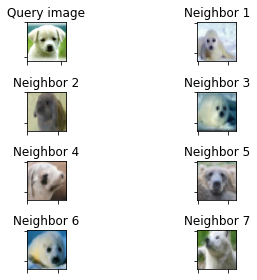

===================== Neighbors for query image 1 =====================


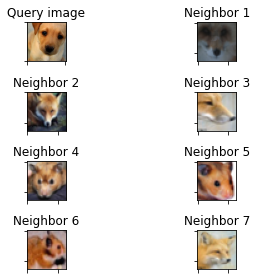

===================== Neighbors for query image 2 =====================


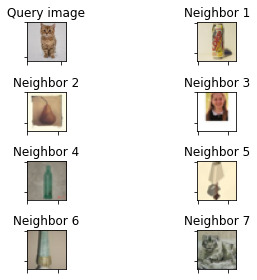

===================== Neighbors for query image 3 =====================


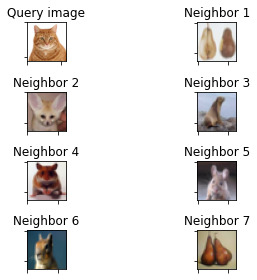

===================== Neighbors for query image 4 =====================


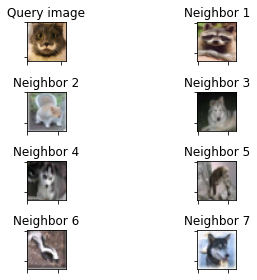

===================== Neighbors for query image 5 =====================


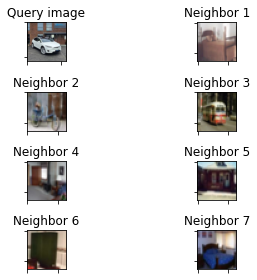

===================== Neighbors for query image 6 =====================


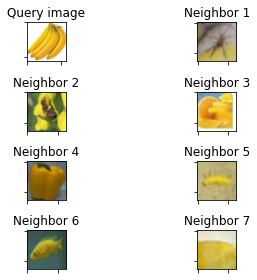

===================== Neighbors for query image 7 =====================


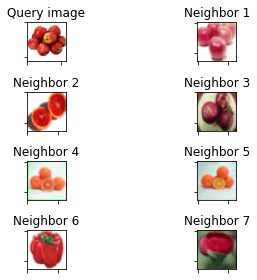

===================== Neighbors for query image 8 =====================


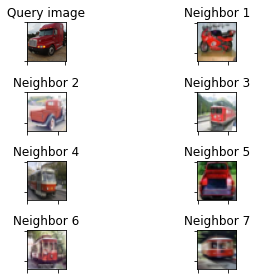

===================== Neighbors for query image 9 =====================


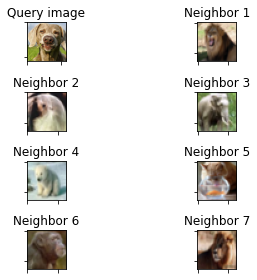

===================== Neighbors for query image 10 =====================


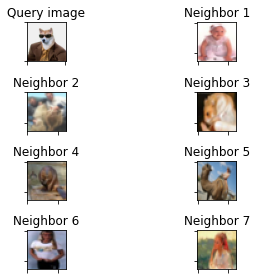

===================== Neighbors for query image 11 =====================


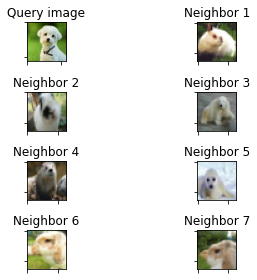

In [11]:
    for i, (orig_path, neighbors) in enumerate(zip(ret_paths, rets_neighbors)):
        print(f"===================== Neighbors for query image {i} =====================")
        neighbors_imgs = [knn[n] for n in neighbors]
        show_neighbors(orig=plt.imread(orig_path), neighbors=neighbors_imgs)

##Looks nice!
The neighbors this algorithm retrieved looks pretty much similar to the query images. That means the the embedding I used is a good representation of the images in these domains. However, for other domains it might be less representative. In addition, one may choose to use other layers (or a combination of those) as embeddings.

##Final Notes

In this post I've showed you a simple algorithm for image retrieval, using neural networks. I hope you enjoyed this and learn something useful :)